In [1]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import nltk
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
stopwords=text.ENGLISH_STOP_WORDS
DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'

In [2]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS
CUSTOM_STOPWORDS=['']

In [3]:
# Read and store csv data in to Master index

bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv',encoding='utf-8')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


In [4]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf1 = bike_masterdf[~desc_mask]
desc_mask2 = bike_subdf1.theft_description == ' '
bike_subdf = bike_subdf1[~desc_mask2]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

#bike_subdf.to_csv(DATAFILEPATH+'stolen_bikes.csv',encoding='utf-8')
bike_subdf.head(20)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 28728


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828
5,5,11540,Motobecane Fantom Cross (pro?),absent,Motobecane,Fantom Cross (pro?),NaN,https://files.bikeindex.org/uploads/Pu/4383/sm...,https://files.bikeindex.org/uploads/Pu/4383/la...,False,True,"Portland, OR, 97202",2013-08-20 06:00:00,2013-08-20 06:00:00,2015-11-03 05:10:30,https://bikeindex.org/bikes/11540,https://bikeindex.org/api/v1/bikes/11540,234,NaN,NaN,NaN,"I'm not sure the size but I'm 6'0"" and the bik...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7887,1376978400,"Portland, OR, 97202",45.489360,-122.652139,Backyard Reward: I have no money,NaN,NaN,NaN,NaN,2014-06-14 17:52:46,False,"4546 SE McLoughlin Blvd, Portland, OR 97202, USA",4546,Southeast McLoughlin Boulevard,97202,Brooklyn,Portland,Multnomah County,Oregon,United States,1376978400,1376978400,1446527430,1402768366
6,6,11541,2007 Trek 7.3 FX WSD,WTU345C2237B,Trek,7.3 FX WSD,2007,NaN,NaN,False,True,"Berkeley, CA, 94709",2009-08-29 06:00:00,2009-09-15 06:00:00,2015-11-03 05:19:08,https://bikeindex.org/bikes/11541,https://bikeindex.org/api/v1/bikes/11541,47,NaN,NaN,15in,Black shiny lady's Trek with custom handlebars...,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7888,1251525600,"Berkeley, CA, 94709",37.876292,-122.273896,Open Garage Reward: $300,NaN,NaN,09-49953,Berkeley,2014-06-14 17:52:49,False,"1843 Virginia St, Berkeley, CA 94703, USA",1843,Virginia Street,94703,North Berkeley,Berkeley,Alameda County,California,United States,1251525600,1252994400,1446527948,1402768369
7,7,11546,2009 Trek 4300,WTU364C1402D,Trek,4300,2009,https://bikebook.s3.amazonaws.com/uploads/Fr/1...,https://bikebook.s3.amazonaws.com/uploads/Fr/1...,True,True,"Washington, DC, 20037",2009-09-07 06:00:00,2009-09-16 06:00:00,2015-11-03 05:19:06,https://bikeindex.org/bik

In [5]:
# Create function to parse incoming text, tokenize ALL words - no filtering 
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")

stemmer = SnowballStemmer("english")

#use nltk tokenizer to tokenize and stem words in incoming sentence 
def clean_and_tokenize(intext):
    intext=re.sub(regex1, ' ', intext)
    intext=re.sub(regex2, ' ', intext)
    intext=re.sub(regex3, ' ', intext)
    
    #tokenize sentence
    dirty_tokens = [word.lower() for sent in nltk.sent_tokenize(intext) for word in nltk.word_tokenize(sent)]
    tokens=[]
    for eacht in dirty_tokens:
        if eacht not in punctuation:
            tokens.append(eacht)
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    
    return " ".join(stemmed_tokens)
    
    


In [6]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def gather_nouns(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)

In [7]:
def gather_nouns_and_adj(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','NNP','JJ','JJR','JJS' ]:
                    if token[4] in CUSTOM_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [8]:
#TEMP  -> testing above parsing functions
atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano\
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was\
stolen from their home's open garage overnight reward"

btext = "Powell Park Reward: $100"
print clean_and_tokenize(atext)
print "\n"
print gather_nouns(atext)
print "\n"
print gather_nouns_and_adj(atext)
print "\n"
print gather_nouns(btext)
print gather_nouns_and_adj(btext)

the bike were lock to a sign pole in my apart by the corner of the superstor the lock was a combin lock and i had tie chain my helmet to the bike we have fair good secur in the block of apart here the bike was of make gt ' with shimanogear and had a custom seat the apart 's secur offic told me that i have no chanc of retriev the bike my counsin ' bike wasstolen from their home 's open garag overnight reward


bike sign pole apartment corner superstore lock combination lock helmet bike security block apartment bike make gt shimanogear custom seat apartment security office chance bike counsin bike home garage reward


bike sign pole apartment corner superstore lock combination lock helmet bike good security block apartment bike make gt shimanogear custom seat apartment security office chance bike counsin bike home open garage overnight reward


powell park reward
powell park reward


In [9]:
# Parse Theft description for Nouns and Adjectives
# Clean resulting data frame to remove null entries where no nouns/adjective were parsed from theft description

noun_parsed = bike_subdf.theft_description.map(gather_nouns)
noun_adj_parsed = bike_subdf.theft_description.map(gather_nouns_and_adj)
noun_parsed = noun_parsed.to_frame()
noun_adj_parsed = noun_adj_parsed.to_frame()
noun_parsed.columns = ['theft_desc_nouns']
noun_adj_parsed.columns = ['theft_desc_nouns_adj'] 

#Merge new dataframe with original
newdf = pd.concat([bike_subdf, noun_parsed, noun_adj_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask = newdf.theft_desc_nouns == ''
bike_df_clean = newdf[~null_mask].copy()
bike_df_clean.head(5)


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch,theft_desc_nouns,theft_desc_nouns_adj
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369,bike rack,bike rack
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828,car bike rack reward,car bike rack reward
5,5,11540,Motobecane Fantom Cross (pro?),absent,Motobecane,Fantom Cross (pro?),NaN,https://files.bikeindex.org/uploads/Pu/4383/sm...,https://files.bikeindex.org/uploads/Pu/4383/la...,False,True,"Portland, OR, 97202",2013-08-20 06:00:00,2013-08-20 06:00:00,2015-11-03 05:10:30,https://bikeindex.org/bikes/11540,https://bikeindex.org/api/v1/bikes/11540,234,NaN,NaN,NaN,"I'm not sure the size but I'm 6'0"" and the bik...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7887,1376978400,"Portland, OR, 97202",45.489360,-122.652139,Backyard Reward: I have no money,NaN,NaN,NaN,NaN,2014-06-14 17:52:46,False,"4546 SE McLoughlin Blvd, Portland, OR 97202, USA",4546,Southeast McLoughlin Boulevard,97202,Brooklyn,Portland,Multnomah County,Oregon,United States,1376978400,1376978400,1446527430,1402768366,backyard reward money,backyard reward money
6,6,11541,2007 Trek 7.3 FX WSD,WTU345C2237B,Trek,7.3 FX WSD,2007,NaN,NaN,False,True,"Berkeley, CA, 94709",2009-08-29 06:00:00,2009-09-15 06:00:00,2015-11-03 05:19:08,https://bikeindex.org/bikes/11541,https://bikeindex.org/api/v1/bikes/11541,47,NaN,NaN,15in,Black shiny lady's Trek with custom handlebars...,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7888,1251525600,"Berkeley, CA, 94709",37.876292,-122.273896,Open Garage Reward: $300,NaN,NaN,09-49953,Berkeley,2014-06-14 17:52:49,False,"1843 Virginia St, Berkeley, CA 94703, USA",1843,Virginia Street,94703,North Berkeley,Berkeley,Alameda County,California,United States,1251525600,1252994400,1446527948,1402768369,garage reward,open garage reward
7,7,11546,2009 Trek 4300,WTU364C1402D,Trek,4300,2009,https://bikebook.s3.amazonaws.com/uploads/

In [10]:
#Write cleaned dataframe to CSV
bike_df_clean.to_csv(DATAFILEPATH+'stolen_bikes_cleaned.csv',encoding='utf-8')

In [11]:
#Tokenize each theft description to return a list of nouns, proper nouns etc for each sample (row)
# We will remove words whose word count is less than 2
vectorizer = CountVectorizer(min_df=2, stop_words='english')
vectorizer_bigram = CountVectorizer(min_df=2, ngram_range=(2,2), stop_words='english')
text_sparse_matrix = vectorizer.fit_transform(bike_df_clean.theft_desc_nouns)
                                            
#Bi-gram only makes sense for adjective and nouns                                              
text_sparse_matrix_bigram = vectorizer_bigram.fit_transform(bike_df_clean.theft_desc_nouns_adj)    


In [12]:
id2words= dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
id2words_bigram= dict((v, k) for k, v in vectorizer_bigram.vocabulary_.iteritems())
corpus_gensim = gensim.matutils.Sparse2Corpus(text_sparse_matrix, documents_columns=False)
corpus_gensim_bigram = gensim.matutils.Sparse2Corpus(text_sparse_matrix_bigram, documents_columns=False)

In [13]:
print "Corpus shape of unigram: ", corpus_gensim.sparse.get_shape()
print "Corpus shape of bigram: ", corpus_gensim_bigram.sparse.get_shape()
print "Number of words in vocabulary:", len(vectorizer.vocabulary_)


Corpus shape of unigram:  (2824, 28434)
Corpus shape of bigram:  (9332, 28434)
Number of words in vocabulary: 2824


In [14]:
#**********************
#
#
#
#
#
#       NEED TO DO LSA for dimensionality reduction
#
#
#
#
#
#
# **********************
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Following N_components is recommended to be set to 100 based on documentation - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# We are testing n_components as 1000 to begin with as it is less than the number of words in the vocabulary - 2824
n_components = 1000
svd = TruncatedSVD(n_components)
svd_bigram = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa_bigram = make_pipeline(svd_bigram, normalizer)

lsa_text_sparse_matrix = lsa.fit_transform(text_sparse_matrix)
lsa_text_sparse_matrix_bigram = lsa_bigram.fit_transform(text_sparse_matrix_bigram)

explained_variance = svd.explained_variance_ratio_.sum()
explained_variance_bigram = svd_bigram.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
print("Explained variance of the SVD Bigram step: {}%".format(int(explained_variance_bigram * 100)))

Explained variance of the SVD step: 94%
Explained variance of the SVD Bigram step: 69%


In [15]:
#Use sparse matrix to initiate K-means clustering    - Without LSA ... This cell is followed by sparse matrix from LSA

from sklearn.cluster import KMeans

num_clusters = np.arange(2,11)
kmeans_model={}
kmeans_bigram_model={}
for i in num_clusters:
    kmeans_model[i] = KMeans(init='k-means++', n_clusters=i, n_init=10, random_state=10)
    kmeans_bigram_model[i] = KMeans(init='k-means++', n_clusters=i, n_init=10, random_state=10)
    %time kmeans_model[i].fit(text_sparse_matrix)
    %time kmeans_bigram_model[i].fit(text_sparse_matrix_bigram)



CPU times: user 4.77 s, sys: 28.3 ms, total: 4.8 s
Wall time: 4.8 s
CPU times: user 2.09 s, sys: 6.37 ms, total: 2.1 s
Wall time: 2.09 s
CPU times: user 9.13 s, sys: 7.93 ms, total: 9.14 s
Wall time: 9.14 s
CPU times: user 2.65 s, sys: 2.57 ms, total: 2.65 s
Wall time: 2.65 s
CPU times: user 8.38 s, sys: 6.31 ms, total: 8.39 s
Wall time: 8.39 s
CPU times: user 4.26 s, sys: 4.8 ms, total: 4.26 s
Wall time: 4.26 s
CPU times: user 12.7 s, sys: 8.09 ms, total: 12.7 s
Wall time: 12.7 s
CPU times: user 3.55 s, sys: 4.71 ms, total: 3.56 s
Wall time: 3.56 s
CPU times: user 10.1 s, sys: 10.3 ms, total: 10.1 s
Wall time: 10.1 s
CPU times: user 4.59 s, sys: 5.18 ms, total: 4.59 s
Wall time: 4.59 s
CPU times: user 11.8 s, sys: 10 ms, total: 11.8 s
Wall time: 11.8 s
CPU times: user 4.6 s, sys: 5.96 ms, total: 4.61 s
Wall time: 4.61 s
CPU times: user 14.7 s, sys: 12.3 ms, total: 14.8 s
Wall time: 14.8 s
CPU times: user 5.28 s, sys: 5.21 ms, total: 5.29 s
Wall time: 5.29 s
CPU times: user 14.2 s, sys

In [16]:
# *******************************************
# ***************************************
#Use LSA sparse matrix to initiate K-means clustering 

from sklearn.cluster import KMeans

num_clusters = np.arange(2,11)
lsa_kmeans_model={}
lsa_kmeans_bigram_model={}
for i in num_clusters:
    lsa_kmeans_model[i] = KMeans(init='k-means++', n_clusters=i, n_init=10, random_state=10)
    lsa_kmeans_bigram_model[i] = KMeans(init='k-means++', n_clusters=i, n_init=10, random_state=10)
    %time lsa_kmeans_model[i].fit(lsa_text_sparse_matrix)
    %time lsa_kmeans_bigram_model[i].fit(lsa_text_sparse_matrix_bigram)

CPU times: user 11.9 s, sys: 210 ms, total: 12.1 s
Wall time: 5.44 s
CPU times: user 13.1 s, sys: 192 ms, total: 13.3 s
Wall time: 5.82 s
CPU times: user 36.3 s, sys: 280 ms, total: 36.6 s
Wall time: 15.2 s
CPU times: user 15.1 s, sys: 219 ms, total: 15.3 s
Wall time: 6.18 s
CPU times: user 33 s, sys: 271 ms, total: 33.2 s
Wall time: 14.1 s
CPU times: user 16.8 s, sys: 223 ms, total: 17 s
Wall time: 7.08 s
CPU times: user 37.7 s, sys: 290 ms, total: 38 s
Wall time: 15.7 s
CPU times: user 29.6 s, sys: 289 ms, total: 29.9 s
Wall time: 12.1 s
CPU times: user 39.9 s, sys: 292 ms, total: 40.2 s
Wall time: 16 s
CPU times: user 26.4 s, sys: 242 ms, total: 26.6 s
Wall time: 10.4 s
CPU times: user 33.2 s, sys: 268 ms, total: 33.5 s
Wall time: 12.6 s
CPU times: user 22.8 s, sys: 231 ms, total: 23.1 s
Wall time: 8.98 s
CPU times: user 41.6 s, sys: 304 ms, total: 41.9 s
Wall time: 16.3 s
CPU times: user 23.4 s, sys: 247 ms, total: 23.6 s
Wall time: 8.83 s
CPU times: user 39.9 s, sys: 292 ms, total

In [17]:
#Credit: http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#example-text-document-clustering-py
# Using NON LSA ... below cell uses LSA

def print_kmeans_top_terms(num_cluster, model_dict, vectorizer_in, model_name):
    num_clusters = np.arange(2,num_cluster)
    for i in num_clusters :
        print "########   KMeans Model for : " , model_name, " ###########"
        print "###### Printing Top terms for ", i," number of clusters ###### "
        order_centroids = model_dict[i].cluster_centers_.argsort()[:, ::-1]
        terms = vectorizer_in.get_feature_names()
        for i in range(0,i):
            print("Cluster %d:" % i)
            for ind in order_centroids[i, :10]:
                print(' %s' % terms[ind])
            print()
        print "================================================================================"
    print "##################################################################################"

In [18]:
#Uses NON LSA 

print_kmeans_top_terms(11, kmeans_model, vectorizer, "Nouns Only" )
print_kmeans_top_terms(11, kmeans_bigram_model, vectorizer_bigram, "Nouns & Adjectives - Bigrams" )


########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  2  number of clusters ###### 
Cluster 0:
 reward
 garage
 home
 apartment
 house
 rack
 porch
 street
 st
 parking
()
Cluster 1:
 bike
 rack
 reward
 lock
 garage
 cable
 apartment
 building
 parking
 car
()
########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  3  number of clusters ###### 
Cluster 0:
 reward
 garage
 home
 apartment
 house
 porch
 rack
 street
 st
 parking
()
Cluster 1:
 bike
 rack
 reward
 garage
 lock
 apartment
 cable
 building
 car
 parking
()
Cluster 2:
 bike
 lock
 rack
 cable
 garage
 frame
 wheel
 apartment
 building
 thief
()
########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  4  number of clusters ###### 
Cluster 0:
 bike
 lock
 rack
 cable
 garage
 apartment
 frame
 wheel
 building
 thief
()
Cluster 1:
 bike
 garage
 lock
 apartment
 home
 house
 porch
 cable
 building
 yard
()
Cluster 2:
 reward
 garage
 ho

In [19]:
#Uses LSA 
print_kmeans_top_terms(11, lsa_kmeans_model, vectorizer, "Nouns Only" )
print_kmeans_top_terms(11, lsa_kmeans_bigram_model, vectorizer_bigram, "Nouns & Adjectives - Bigrams" )

########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  2  number of clusters ###### 
Cluster 0:
 00pm
 12
 100
 1000
 205
 14
 25
 20s
 15
 academy
()
Cluster 1:
 100
 00pm
 1000
 30
 5th
 abus
 7th
 ace
 45
 appointment
()
########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  3  number of clusters ###### 
Cluster 0:
 100
 00pm
 1000
 30
 5th
 abus
 7th
 ace
 45
 appointment
()
Cluster 1:
 00pm
 12
 100
 14
 access
 accident
 adult
 45pm
 15
 address
()
Cluster 2:
 1000
 00pm
 205
 25
 14
 20s
 12
 15
 accomplice
 academy
()
########   KMeans Model for :  Nouns Only  ###########
###### Printing Top terms for  4  number of clusters ###### 
Cluster 0:
 1000
 100
 12
 00pm
 14
 45
 accessory
 access
 45pm
 50
()
Cluster 1:
 100
 00pm
 30
 abus
 5th
 7th
 accent
 ace
 alcohol
 appx
()
Cluster 2:
 00pm
 205
 1000
 25
 20s
 15
 academy
 accomplice
 ability
 50
()
Cluster 3:
 00pm
 12
 100
 14
 205
 access
 15
 accent
 address
 ac

In [20]:
#TEMP
model_labels = kmeans_model[2].labels_
print (model_labels.shape)
lsa_model_labels = lsa_kmeans_model[2].labels_
print (lsa_model_labels.shape)

(28434,)
(28434,)


In [21]:
def print_kmeans_cluster_center(num_cluster, model_dict, model_name):
    #num_clusters = np.arange(2,num_cluster)
    print " ### Cluster Center for ", model_name, " #####" 

    #for i in num_clusters:
    #    print "Printing cluster centers for Kmeans with ", i, " number of clusters"
    #    print model_dict[i].cluster_centers_

        
num_cluster = 11
print_kmeans_cluster_center(num_cluster, kmeans_model, "Kmeans Model Nouns only")
print_kmeans_cluster_center(num_cluster, kmeans_bigram_model, "Kmeans Model Nouns & Adjectives - Bigrams")


 ### Cluster Center for  Kmeans Model Nouns only  #####
 ### Cluster Center for  Kmeans Model Nouns & Adjectives - Bigrams  #####


In [22]:
# Using Cosine similarity instead of euclidean distance
from sklearn.metrics.pairwise import cosine_similarity

#Convert sparse matrix to full array
text_full_matrix = text_sparse_matrix.toarray()
text_full_matrix_bigram = text_sparse_matrix_bigram.toarray()


#Cosine Similarity:  reference paper:
#    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.332.4480&rep=rep1&type=pdf
# Notes from Paper above:  
#
#When documents are represented as term vectors, the sim- ilarity of two documents corresponds to the correlation be- tween the vectors. This is quantified as the cosine of the angle between vectors, that is, the so-called cosine similar- ity. Cosine similarity is one of the most popular similarity measure applied to text documents, such as in numerous in- formation retrieval applications [21] and clustering too 
#An important property of the cosine similarity is its inde- pendence of document length 
#the standard K-means algo- rithm is chosen as the clustering algorithm. This is an itera- tive partitional clustering process that aims to minimize the least squares error criterion 
#partitional clustering algorithms have been recognized to be better suited for handling large document datasets than hi- erarchical ones, due to their relatively low computational requirements 
#The K-means algorithm works with distance measures which basically aims to minimize the within-cluster distances. There- fore, similarity measures do not directly fit into the algo- rithm, because smaller values indicate dissimilarity. The Euclidean distance and the averaged KL divergence are dis- tance measures, while the cosine similarity, Jaccard coef- ficient and Pearson coefficient are similarity measures. 
#we take 1- cosine similarity as the distance value
#Cosine is a measure of similarity. So we subtract from 1 to get the distance since max value of cos is 1
%time distance_cos = 1 - cosine_similarity(text_full_matrix)
%time distance_cos_bigram = 1 - cosine_similarity(text_full_matrix_bigram)

CPU times: user 3min 52s, sys: 6.87 s, total: 3min 59s
Wall time: 48.8 s
CPU times: user 11min 49s, sys: 12.4 s, total: 12min 1s
Wall time: 1min 57s


#Compute MDS for Display of points
templabel = np.arange(0,29838)
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)  #*******************  Try changing N_components
#Fit distance (calculated earlier ) to MDS and obtain embedded coordinates
pos = mds.fit_transform(distance_cos)

#Plot graph
xs, ys = pos[:, 0], pos[:, 1]
for x, y in zip(xs, ys):
    #color = 'orange' if "Austen" in name else 'skyblue'
    plt.scatter(x, y)
    plt.text(x, y)

plt.show()


In [23]:
#TEMP:
text_sparse_matrix.shape[0]

28434

Automatically created module for IPython interactive environment
For n_clusters =

/Users/Dilip_MBP/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/Dilip_MBP/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 2  The average silhouette_score is : 0.0


/Users/Dilip_MBP/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


ValueError: axis(=-1) out of bounds

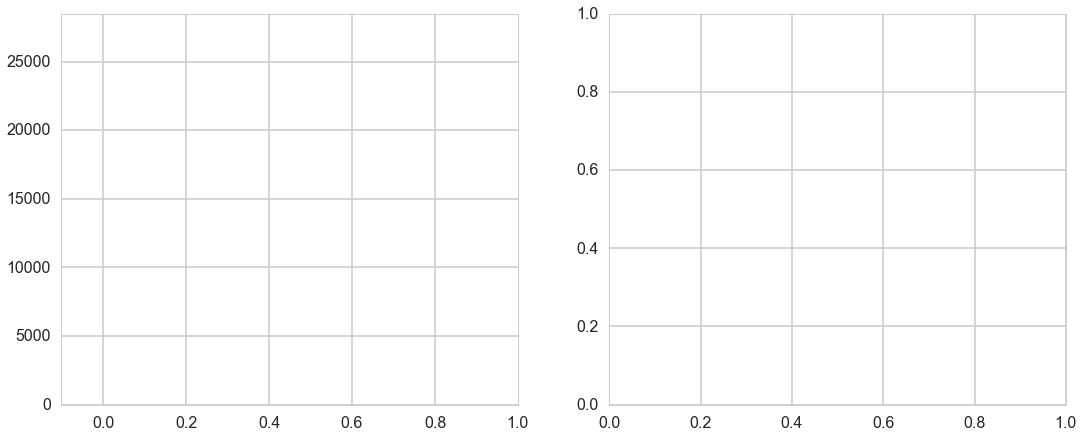

In [24]:
#Silhouette Analysis on K-means
# Credit: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#example-cluster-plot-kmeans-silhouette-analysis-py
from __future__ import print_function

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distict cluster and 3 clusters placed close
# together.


range_n_clusters = [2, 3, 4, 5, 6]
temp_labels = np.array(['1','2','3','4', '5'])

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, text_sparse_matrix.shape[0] + (n_clusters + 1) * 10])



    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #**************************************************
    #**************************************************
    #silhouette_avg = silhouette_score(X)  #default value for metric is euclidean
    silhouette_avg = silhouette_score(text_sparse_matrix, temp_labels, metric='cosine')
    
    print("For n_clusters =", n_clusters, " The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(text_sparse_matrix,temp_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[temp_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(temp_labels.astype(float) / n_clusters)
    ax2.scatter(text_sparse_matrix[:, 0], text_sparse_matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [ ]:
temp_labels=np.arange(1,text_sparse_matrix.shape[0]+1)
sample_silhouette_values = silhouette_samples(text_sparse_matrix,temp_labels)
sample_silhouette_values    

In [ ]:
text_sparse_matrix.shape[0]